In [30]:
import datetime
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from pyriemann.utils.viz import plot_confusion_matrix

In [2]:
def load_dataset(user_split = True):
    X_train = None
    y_train_medid = None
    y_train_subjid = None
    X_val = None
    y_val_medid = None
    y_val_subjid = None
    X_test = None
    y_test_medid = None
    y_test_subjid = None

    # user_split: Determines the creation of train/val/test set. In user_split, test/val users are never seen during the train. time_split randomly splits each user's chunks into train/val/test.
    if user_split:
        data_file_path = '../../data/Meditation/user_based_splits.pkl'
    else:
        data_file_path = '../../data/Meditation/time_based_splits.pkl'

    with open(data_file_path, 'rb') as f:
        all_data_splits = pickle.load(f)

        X_train = all_data_splits['train']['x']
        y_train_medid = all_data_splits['train']['y_med']
        y_train_subjid = all_data_splits['train']['y_subj']

        X_val = all_data_splits['val']['x']
        y_val_medid = all_data_splits['val']['y_med']
        y_val_subjid = all_data_splits['val']['y_subj']

        X_test = all_data_splits['test']['x']
        y_test_medid = all_data_splits['test']['y_med']
        y_test_subjid = all_data_splits['test']['y_subj']

    return X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid

In [3]:
x_train, y_train, y_train_subjid, x_val, y_val, y_val_subjid, x_test, y_test, y_test_subjid = load_dataset(user_split=True)

In [4]:
# meditation technique classification using user splits

num_classes = 4
input_shape = (64, 2560, 1)

x_train = np.reshape(x_train, (x_train.shape[0], 64, 2560, 1))
x_val   = np.reshape(x_val, (x_val.shape[0], 64, 2560, 1))
x_test  = np.reshape(x_test, (x_test.shape[0], 64, 2560, 1))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (2057, 64, 2560, 1) - y_train shape: (2057,)
x_val shape: (631, 64, 2560, 1) - y_val shape: (631,)
x_test shape: (615, 64, 2560, 1) - y_test shape: (615,)


In [31]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 500
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [33]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 256


<Figure size 640x480 with 0 Axes>

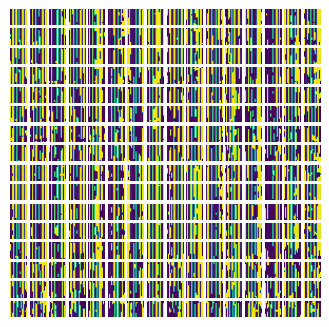

In [35]:
plt.show()

In [36]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )
    
    log_dir = "./ckpt/vitlogs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
    checkpoint_filepath = "./ckpt/checkpoint_vit"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, tensorboard_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_2_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")
    preds = model.predict(x_test)
    y_pred = preds.argmax(axis = -1)
    
    plt.figure(0)
    plot_confusion_matrix(y_pred, y_test, ["HT", "SNY", "VIP", "CTR"], title = 'ViT-256')
    
    plt.savefig('vit_clsr.png')
    plt.show()
    return preds


vit_classifier = create_vit_classifier()
preds = run_experiment(vit_classifier)


Layer Patches has arguments ['self', 'patch_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/500
129/129 [==============================] - 98s 690ms/step - loss: 3.1481 - accuracy: 0.2956 - top-2-accuracy: 0.5440 - val_loss: 1.4654 - val_accuracy: 0.2631 - val_top-2-accuracy: 0.4517
Epoch 2/500
129/129 [==============================] - 83s 643ms/step - loss: 1.4876 - accuracy: 0.3199 - top-2-accuracy: 0.5712 - val_loss: 1.4752 - val_accuracy: 0.2155 - val_top-2-accuracy: 0.4802
Epoch 3/500
129/129 [==============================] - 84s 648ms/step - loss: 1.3597 - accuracy: 0.3554 - top-2-accuracy: 0.6018 - val_loss: 1.4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129/129 [==============================] - 84s 651ms/step - loss: 0.2168 - accuracy: 0.9324 - top-2-accuracy: 0.9869 - val_loss: 4.6789 - val_accuracy: 0.2900 - val_top-2-accuracy: 0.5436
Epoch 87/500
129/129 [==============================] - 84s 652ms/step - loss: 0.1737 - accuracy: 0.9431 - top-2-accuracy: 0.9874 - val_loss: 5.0178 - val_accuracy: 0.2884 - val_top-2-accuracy: 0.4469
Epoch 88/500
129/129 [==============================] - 83s 646ms/step - loss: 0.1456 - accuracy: 0.9480 - top-2-accuracy: 0.9893 - val_loss: 4.1307 - val_accuracy: 0.2583 - val_top-2-accuracy: 0.5452
Epoch 89/500
129/129 [==============================] - 84s 653ms/step - loss: 0.1583 - accuracy: 0.9460 - top-2-accuracy: 0.9917 - val_loss: 4.6162 - val_accuracy: 0.2108 - val_top-2-accuracy: 0.4913
Epoch 90/500
129/129 [==============================] - 85s 657ms/step - loss: 0.1164 - accuracy: 0.9611 - top-2-accuracy: 0.9912 - val_loss: 5.3277 - val_accuracy: 0.2694 - val_top-2-accuracy: 0.5642
Epoch 91

Epoch 127/500
129/129 [==============================] - 85s 661ms/step - loss: 0.1297 - accuracy: 0.9558 - top-2-accuracy: 0.9932 - val_loss: 5.6064 - val_accuracy: 0.2488 - val_top-2-accuracy: 0.3914
Epoch 128/500
129/129 [==============================] - 85s 662ms/step - loss: 0.0988 - accuracy: 0.9674 - top-2-accuracy: 0.9961 - val_loss: 6.4688 - val_accuracy: 0.2599 - val_top-2-accuracy: 0.5293
Epoch 129/500
129/129 [==============================] - 86s 665ms/step - loss: 0.1234 - accuracy: 0.9567 - top-2-accuracy: 0.9947 - val_loss: 4.6016 - val_accuracy: 0.2219 - val_top-2-accuracy: 0.4326
Epoch 130/500
129/129 [==============================] - 85s 660ms/step - loss: 0.1158 - accuracy: 0.9684 - top-2-accuracy: 0.9927 - val_loss: 4.2488 - val_accuracy: 0.2599 - val_top-2-accuracy: 0.4374
Epoch 131/500
129/129 [==============================] - 85s 657ms/step - loss: 0.1243 - accuracy: 0.9631 - top-2-accuracy: 0.9937 - val_loss: 6.1600 - val_accuracy: 0.2536 - val_top-2-accurac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129/129 [==============================] - 85s 659ms/step - loss: 0.0957 - accuracy: 0.9684 - top-2-accuracy: 0.9971 - val_loss: 4.6973 - val_accuracy: 0.2013 - val_top-2-accuracy: 0.4089
Epoch 212/500
129/129 [==============================] - 86s 664ms/step - loss: 0.0907 - accuracy: 0.9703 - top-2-accuracy: 0.9947 - val_loss: 5.6973 - val_accuracy: 0.2155 - val_top-2-accuracy: 0.3930
Epoch 213/500
129/129 [==============================] - 85s 658ms/step - loss: 0.0858 - accuracy: 0.9728 - top-2-accuracy: 0.9956 - val_loss: 6.1154 - val_accuracy: 0.2266 - val_top-2-accuracy: 0.4897
Epoch 214/500
129/129 [==============================] - 87s 672ms/step - loss: 0.0862 - accuracy: 0.9718 - top-2-accuracy: 0.9947 - val_loss: 5.7606 - val_accuracy: 0.2345 - val_top-2-accuracy: 0.5087
Epoch 215/500
129/129 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9631 - top-2-accuracy: 0.9932

In [39]:
print("Done")

Done


In [45]:
plot_confusion_matrix(preds.argmax(axis = -1), y_test, ["HT", "SNY", "VIP", "CTR"], title = 'ViT-256')

<AxesSubplot:title={'center':'ViT-256'}, xlabel='Predicted label', ylabel='True label'>

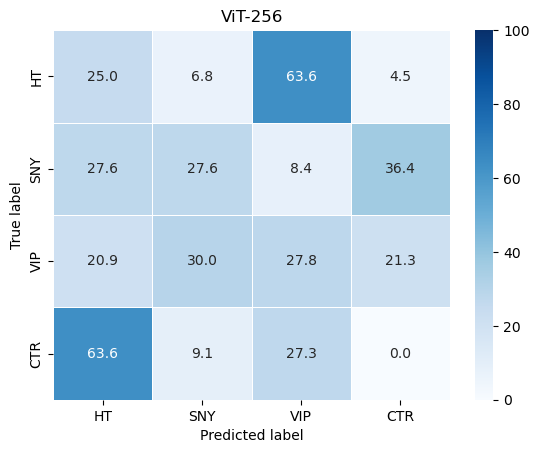

In [46]:
plt.savefig('vit_clsr.png')
plt.show()